# TP1

Se realizan inicializaciones que son comunes a todos los ejercicios

In [1]:
# Inicializaciones

%matplotlib inline
#%matplotlib qt

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
def plot_images(images, images2=None, cmap_left=None, cmap_right=None):
    """
    Grafica una lista de imágenes con sus respectivos títulos. Si se proporciona una segunda lista,
    se muestra a la derecha permitiendo compararlas.

    Parámetros:
    images (lista de tuplas): Una lista donde cada elemento es una tupla que contiene
                             una imagen (como un NumPy array) y un título (str).
    images (lista de tuplas): Una lista opcional donde cada elemento es una tupla que contiene
                             una imagen (como un NumPy array) y un título (str).
    cmap_left: Nombre de mapa de color para mostrar la imagen izquierda.
    cmap_right: Nombre de mapa de color para mostrar la imagen derecha.
    """
    num_images = len(images)
    columns = 2 if images2 else 1

    # El tamaño depende de la cantidad de imágenes y columnas
    plt.figure(figsize=(5 * columns, 5 * num_images))

    for i, (img1, title1) in enumerate(images):
        plt.subplot(num_images, columns, i * columns + 1)
        plt.imshow(img1, cmap=cmap_left)
        plt.title(title1)
        plt.axis('off')
        
        if images2:
            img2, title2 = images2[i]
            plt.subplot(num_images, columns, i * columns + 2)
            plt.imshow(img2, cmap=cmap_right)
            plt.title(title2)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

## Parte 1 (imágenes en /white_patch y /coord_cromaticas):
### 1. Implementar el algoritmo de pasaje a coordenadas cromáticas para librarnos de las variaciones de contraste.

In [3]:
def coord_cromaticas(img_input: np.ndarray) -> np.ndarray:
    """
    Parameters
    ----------
    img_input:np.ndarray 
        Imagen de entrada
    
    Return
    ------
    img: (numpy.ndarray) imagen con coordenadas cromáticas
    """
    img_new = np.zeros_like(img_input, dtype=float)

    # Se suman los tres canales para cada píxel de la imagen de entrada.
    # Se castean a int porque al leer la imagen se asumieron los valores como uint8 y al superar 255 en la suma habría overflow
    sum_channels = img_input[:,:,0].astype(int) + img_input[:,:,1].astype(int) + img_input[:,:,2].astype(int)
    
    # Para evitar división por 0 en los pasos siguientes
    sum_channels[sum_channels == 0] = 1
    
    # Se agrega una nueva dimensión de forma que se pueda hacer broadcasting en el siguiente paso
    sum_channels = sum_channels[..., np.newaxis]

    # Se divide el valor de cada canal por la suma de los tres
    img_new = img_input / sum_channels
    
    return img_new

### 2. Implementar el algoritmo White Patch para librarnos de las diferencias de color de iluminación.

In [4]:
def white_patch(img_input: np.ndarray, img_name='', percentile = 95) -> np.ndarray:
    """
    Parameters
    ----------
    img_entrada:np.ndarray 
        Imagen de entrada
    percentil: Percentil a utilizar en cada canal RGB cuando los tres sean 255
    
    Return
    ------
    img: (numpy.ndarray) imagen con ajuste de White Patch
    """
    # Se castean los valores de los tres canales a float para permitir cálculos con mayor precisión
    img_input = img_input.astype(np.float32)
    
    # Se calcula el máximo para cada canal (R, G y B)
    max_rgb = np.max(img_input, axis=(0, 1))

    # Si los tres canales alcanzan el valor máximo se utiliza el percentil
    if np.allclose(max_rgb, [255., 255., 255.]):
        print(f'Advertencia: el máximo RGB para {img_name} es (255,255,255), se utiliza percentil')
        percentile_rgb = np.percentile(img_input, percentile, axis=(0,1))
        img_new = (img_input / percentile_rgb) * 255.0
        img_new = np.minimum(img_new, 255.0)
    else:
        img_new = (img_input / max_rgb) * 255.0


    # Se vuelven a convertir los valores a enteros
    img_new = img_new.astype(np.uint8)
    
    return img_new

### 3. Mostrar los resultados obtenidos y analizar las posibles fallas (si es que las hay) en el caso de White patch.

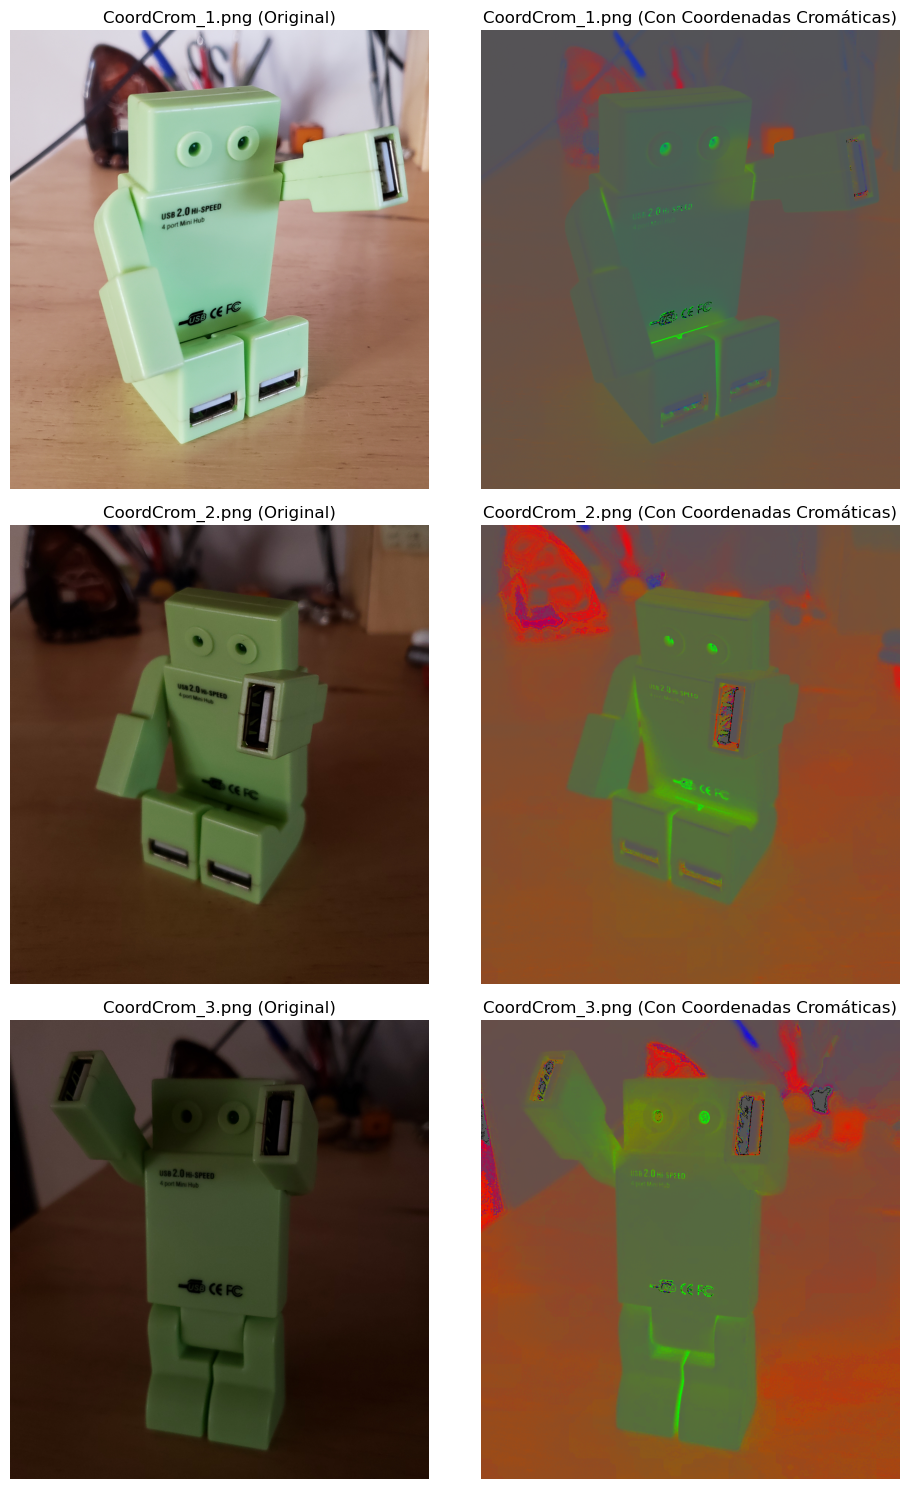

In [7]:
# Se muestra el resultado aplicado a las imágenes de ejemplo para el algoritmo de Coordenadas Cromáticas

image_files = ['CoordCrom_1.png', 'CoordCrom_2.png', 'CoordCrom_3.png']

images_original = []
images_processed = []
for file in image_files:
    img = cv.imread(f'./MaterialTP/coord_cromaticas/{file}')
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images_original.append((img_rgb, f'{file} (Original)'))
    processed_img = coord_cromaticas(img_rgb)
    images_processed.append((processed_img, f'{file} (Con Coordenadas Cromáticas)'))

plot_images(images_original, images_processed)

Advertencia: el máximo RGB para wp_blue.jpg es (255,255,255), se utiliza percentil


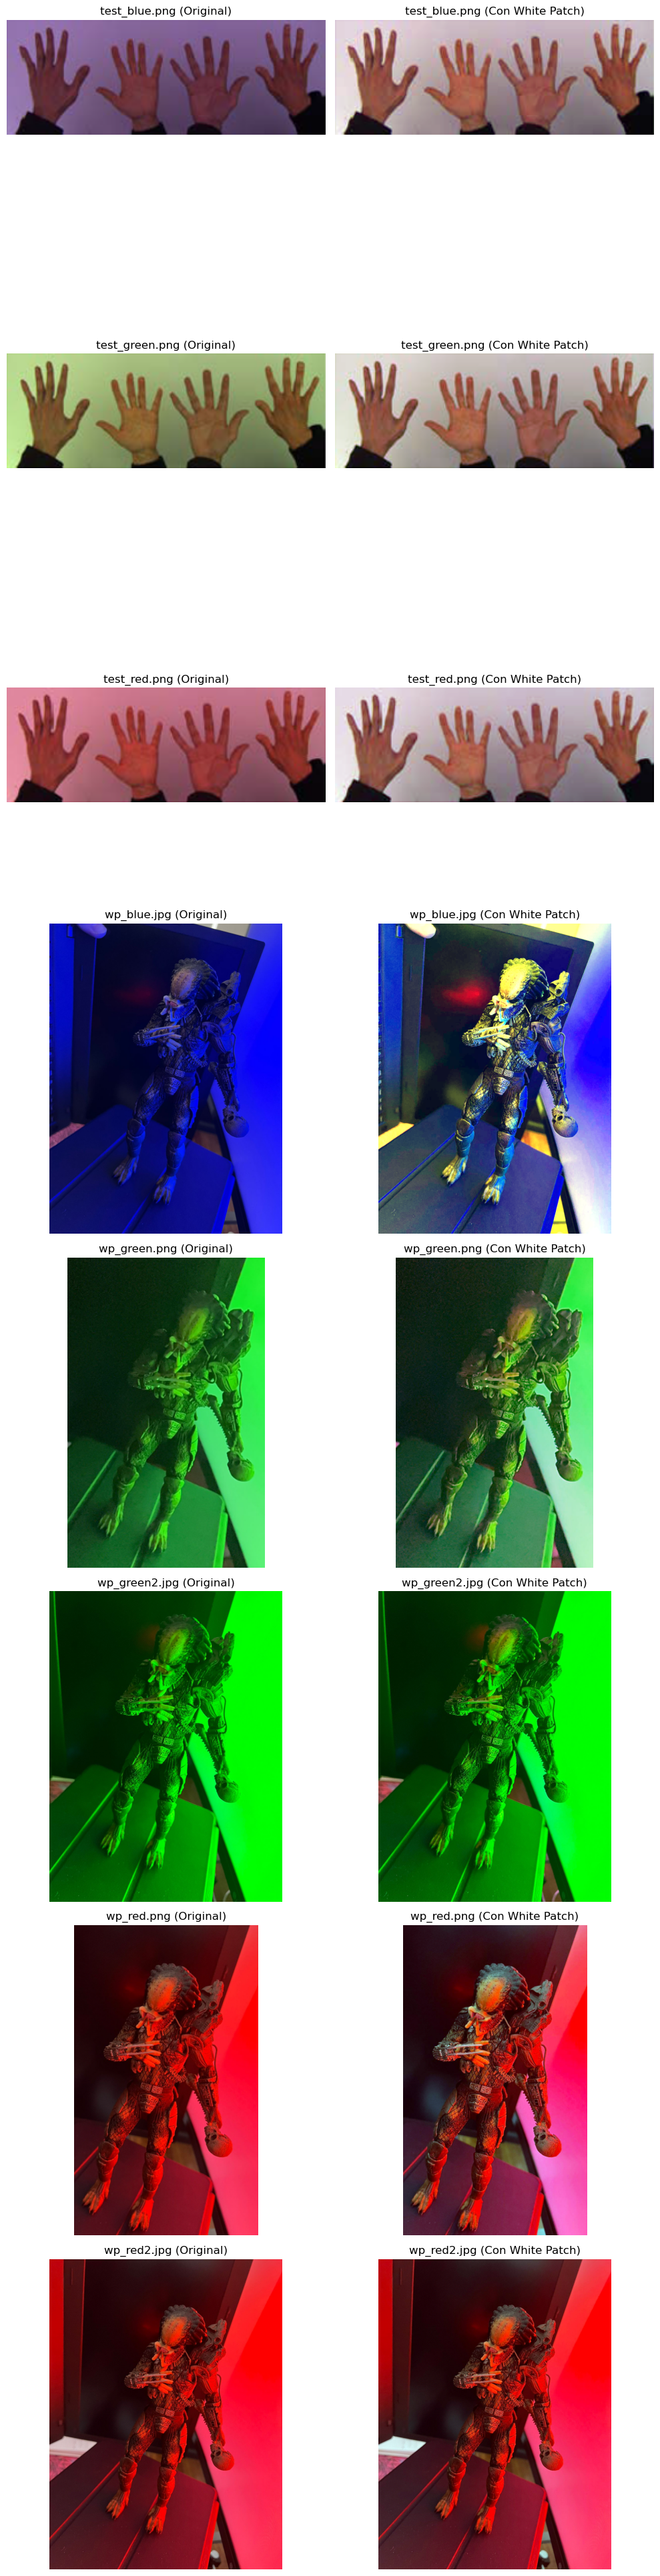

In [9]:
# Se muestran los resultados obtenidos para cada una de las imágenes de ejemplo para el algoritmo de White Patch

image_files = ['test_blue.png', 'test_green.png', 'test_red.png', 'wp_blue.jpg', 'wp_green.png', 'wp_green2.jpg', 'wp_red.png', 'wp_red2.jpg']

images_original = []
images_processed = []
for file in image_files:
    img = cv.imread(f'./MaterialTP/white_patch/{file}')
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    images_original.append((img_rgb, f'{file} (Original)'))
    processed_img = white_patch(img_rgb, file, 95)
    images_processed.append((processed_img, f'{file} (Con White Patch)'))

plot_images(images_original, images_processed)

En el caso del algoritmo de Patch White, se puede detectar que hay una imagen (wp_blue.png) cuyo máximo valor para los tres canales R, G y B es 255. Esto se debe a que hay una pequeña región en la parte superior que es totalmente blanca y genera un desbalance con el resto de la imagen que tiende a ser en su mayor parte en tonos de azul y oscuros. En este caso el algoritmo varía y aplica un percentil (ej. 95) para cada canal de forma de que sea menos sensible a esos valores atípicos. A su vez, al utiliza un percentil y no el valor máximo, el cálculo:

img_new = (img_input / percentile_rgb) * 255.0

podría ser mayor que 255 (ej. en la región totalmente blanca). Es por esto que luego se toma el mínimo entre el valor calculado y 255 para evitar que el resultado quede fuera del rango uint8.

## Parte 2:
### 1. Para las imágenes img1_tp.png y img2_tp.png leerlas con OpenCV en escala de grises y visualizarlas.

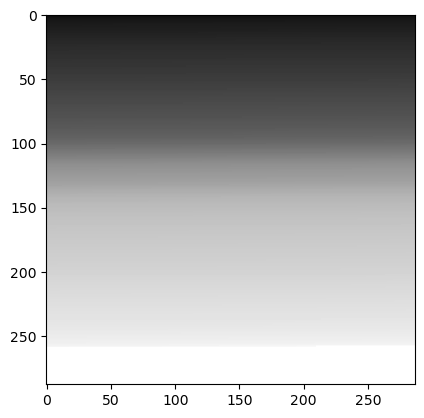

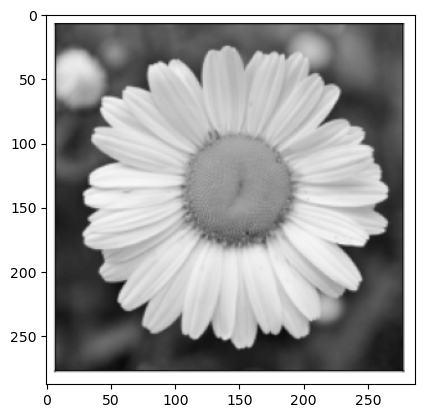

In [11]:
# Se cargan las imágenes en modo monocromático
img1_tp = cv.imread('./MaterialTP/img1_tp.png', cv.IMREAD_GRAYSCALE)
img2_tp = cv.imread('./MaterialTP/img2_tp.png', cv.IMREAD_GRAYSCALE)

# Se visualizan las imágenes
plt.imshow(img1_tp, cmap='gray')
plt.show()

plt.imshow(img2_tp, cmap='gray')
plt.show()

### 2. Elija el numero de bins que crea conveniente y grafique su histograma, compare los histogramas entre si. Explicar lo que se observa, si tuviera que entrenar un modelo de clasificación/detección de imágenes, considera que puede ser de utilidad tomar como ‘features’ a los histogramas?

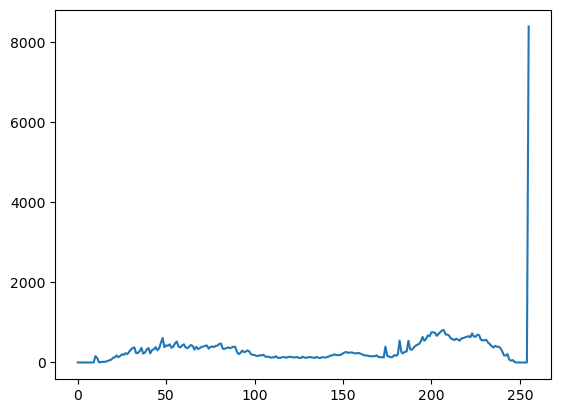

In [12]:
hist1, bins1 = np.histogram(img1_tp.ravel(), 256, [0, 256])
plt.plot(hist1)
plt.show()

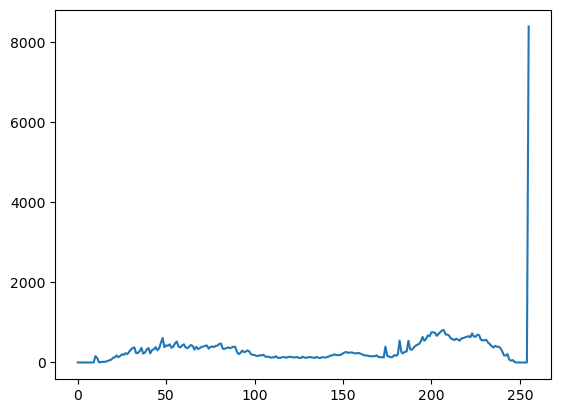

In [13]:
hist2, bins2 = np.histogram(img2_tp.ravel(), 256, [0, 256])
plt.plot(hist2)
plt.show()

Los dos histogramas aparentan ser muy similares, por lo que se realizará una comparación de ambos:

In [14]:
hist_comp = hist1 == hist2
hist_comp.all()

True

Efectivamente son exactamente iguales. Este es un claro ejemplo de que dos imágenes totalmente diferentes podrían tener exactamente el mismo histograma. Si bien es difícil que suceda con imágenes "reales", es una clara señal de que al menos por si solos no son suficientes para un modelo de clasificación. Tal vez en combinación con otras features puedan aportar algo de información, pero se debería analizar según el problema a tratar.

### 3. Para la imagen segmentacion.png analice el histograma de los canales RGB. Segmente algunos de los elementos presentes en la imagen (agua, cielo, tierra) y muestre, aplicando mascaras, las regiones en imágenes separadas.

A continuación se muestra la imagen original y también el resultado de aplicar los filtros antes implementados. Se puede notar que la imagen con White Patch es en general más adecuada que la original ya que no es tan sensible a la iluminación. Además, en el caso de Coordenadas Cromáticas se aprecia que la tierra presenta un color más uniforme que en la imagen original.

Advertencia: el máximo RGB para segmentacion.png es (255,255,255), se utiliza percentil


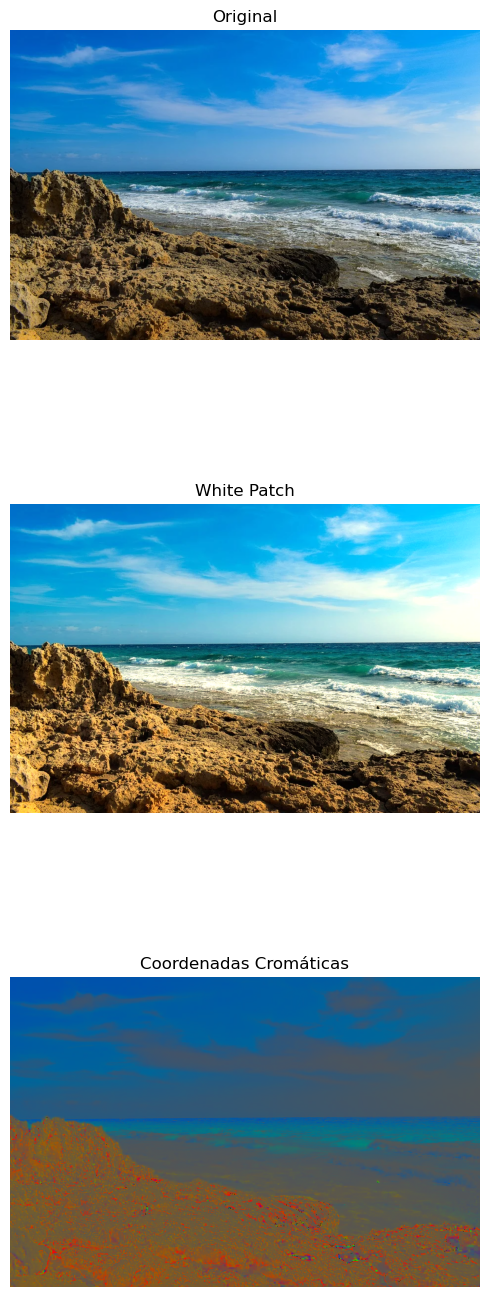

In [15]:
# Se carga la imagen indicada
img_seg_color = cv.imread('./MaterialTP/segmentacion.png')
img_seg_RGB = cv.cvtColor(img_seg_color, cv.COLOR_BGR2RGB)

imgRGB_wp = white_patch(img_seg_RGB, 'segmentacion.png')
imgRGB_cc = coord_cromaticas(img_seg_RGB)

plot_images([(img_seg_RGB, 'Original'), (imgRGB_wp, 'White Patch'), (imgRGB_cc, 'Coordenadas Cromáticas')])

Se toman las muestras lo suficientemente representativas que permitan segmentar los diferentes elementos de la imagen.

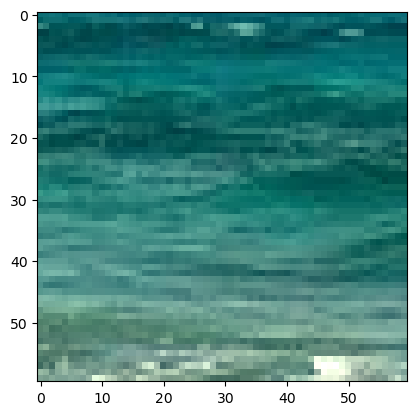

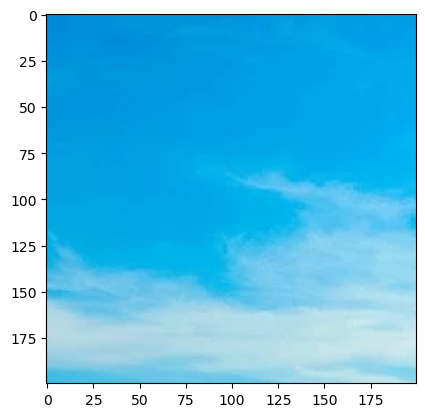

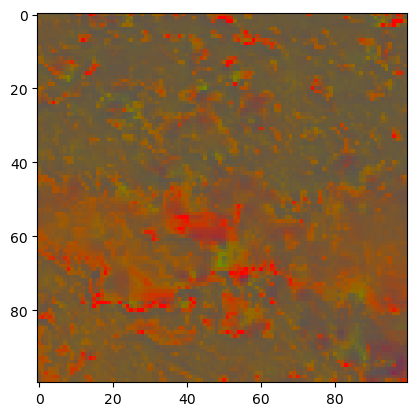

In [16]:
img_muestra_agua = imgRGB_wp[300:360, 600:660,:]
plt.imshow(img_muestra_agua)
plt.show()

img_muestra_cielo = imgRGB_wp[0:200, 400:600,:]
plt.imshow(img_muestra_cielo)
plt.show()

# En este caso se toma la muestra de la imagen procesada con Coordenadas Cromáticas
img_muestra_tierra = imgRGB_cc[500:600, 300:400,:]
plt.imshow(img_muestra_tierra)
plt.show()

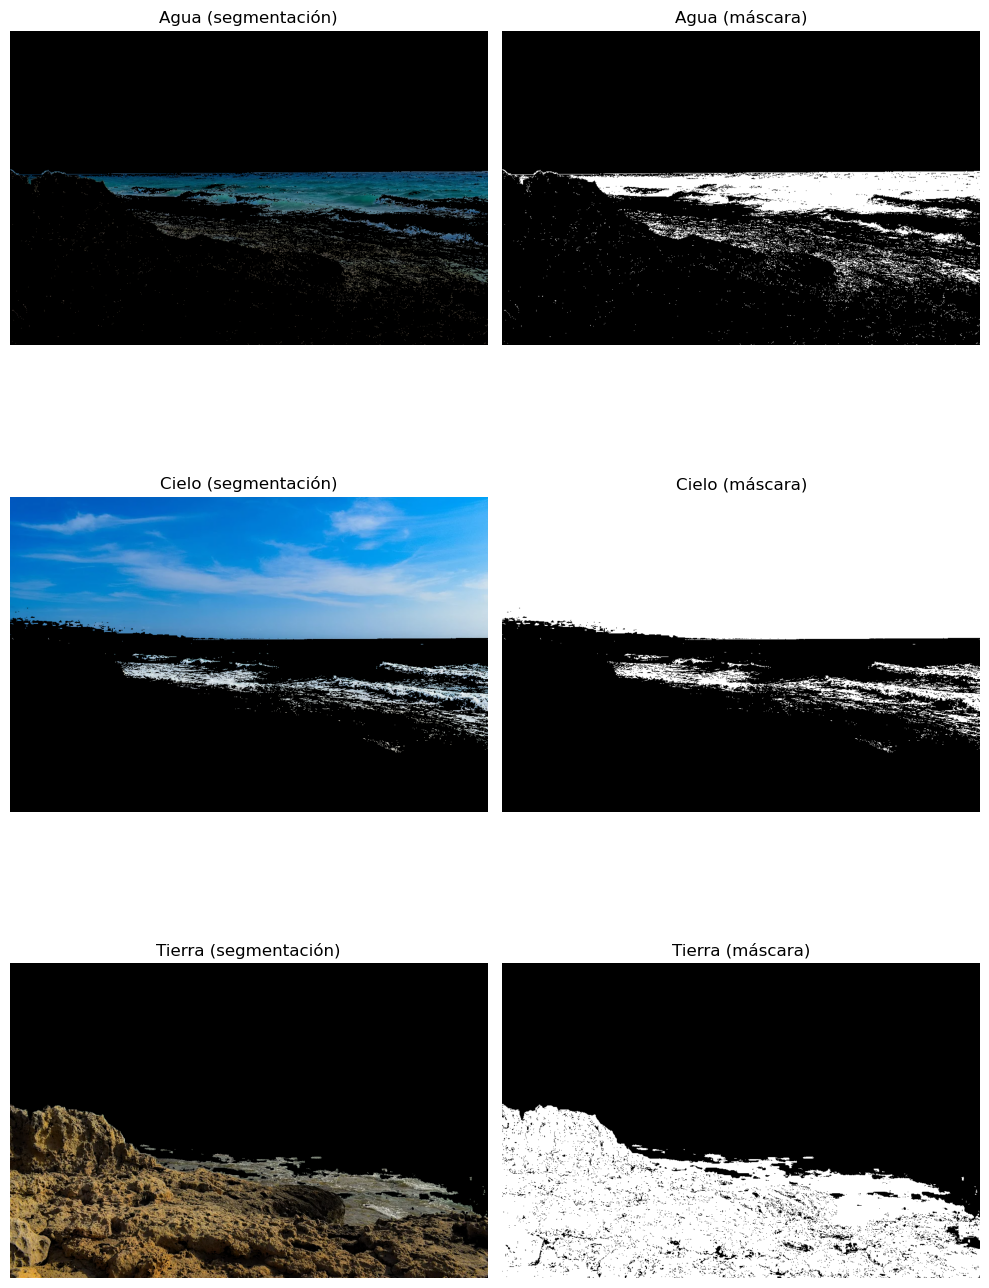

In [17]:
# Se utiliza un modelo estadístico simple para caracterizar los colores de los diferentes elementos
color_mean_agua, color_std_agua = cv.meanStdDev(img_muestra_agua)
color_mean_cielo, color_std_cielo = cv.meanStdDev(img_muestra_cielo)
color_mean_tierra, color_std_tierra = cv.meanStdDev(img_muestra_tierra)

images_segmentadas = []
images_masks = []

# Se obtienen las máscaras aplicando el estadístico y variando el valor de n_sigma hasta obtener un resultado aceptable.

n_sigma = 2
mask_agua = cv.inRange(imgRGB_wp, color_mean_agua-color_std_agua * n_sigma,  color_mean_agua+color_std_agua * n_sigma)
img_segmentada_agua = cv.bitwise_and(img_seg_RGB, img_seg_RGB, mask=mask_agua)
images_segmentadas.append((img_segmentada_agua, 'Agua (segmentación)'))
images_masks.append((mask_agua, 'Agua (máscara)'))

n_sigma = 5
mask_cielo = cv.inRange(imgRGB_wp, color_mean_cielo-color_std_cielo * n_sigma,  color_mean_cielo+color_std_cielo * n_sigma)
img_segmentada_cielo = cv.bitwise_and(img_seg_RGB, img_seg_RGB, mask=mask_cielo)
images_segmentadas.append((img_segmentada_cielo, 'Cielo (segmentación)'))
images_masks.append((mask_cielo, 'Cielo (máscara)'))

n_sigma = 2
mask_tierra= cv.inRange(imgRGB_cc, color_mean_tierra-color_std_tierra * n_sigma,  color_mean_tierra+color_std_tierra * n_sigma)
img_segmentada_tierra = cv.bitwise_and(img_seg_RGB, img_seg_RGB, mask=mask_tierra)
images_segmentadas.append((img_segmentada_tierra, 'Tierra (segmentación)'))
images_masks.append((mask_tierra, 'Tierra (máscara)'))

# Se grafican los resultados
plot_images(images_segmentadas, images_masks, cmap_right='gray')

La clasificación, pese a utilizar un estadístico muy simple, es bastante buena. El mayor desafío se presenta en el agua y el cielo, ya que están muy cercanos en el espacio de color para las imágenes que se usaron para la segmentación. Se podrían implementar otras alternativas, pero es un problema bastante complejo que incluso sería desafiante para algoritmos más avanzados.

Se podrían haber tomado más muestras de la tierra para obtener una máscara más completa, pero se intentó hacerlo de la forma más simple posible de forma de hacerlo no tan a medida de este caso particular.

En conclusión, se puede deducir que dependiendo de lo que se quiera segmentar es conveniente abordar el problema con algoritmos sencillos como éste y luego, en caso de no tener éxito, intentar con técnicas más avanzadas. Para este caso se obtuvieron resultados que podrían ser aceptables en diferentes contextos.